<a href="https://colab.research.google.com/github/BOSS-Danuphan/nlp_tutorial/blob/master/thai_eng_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention [Thai-Eng]
This note book is based from [TensorFlow Tutorial](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention).

Thai-Eng Dataset: http://www.manythings.org/anki/tha-eng.zip

Problem: Seems training set is too small so the performance is teribly bad !!!

Dependencies:
1. [TensorFlow 2.0](https://www.tensorflow.org/beta/)
2. [PyThaiNLP](https://github.com/PyThaiNLP/pythainlp)
3. Matplotlib
4. scikit-learn

In [0]:
%matplotlib inline
from __future__ import absolute_import, division, print_function

!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

!pip install pythainlp
import pythainlp

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import re
import numpy as np
import os
import io
import time

In [0]:
# To fix display Thai in matplotlib
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf

matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='TH Sarabun New')

In [3]:
tf.__version__

'2.0.0-beta1'

In [4]:
!python --version

Python 3.6.8


In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


## Download and prepare the dataset
We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:
```
I think you're right.	ฉันคิดว่าคุณพูดถูก
```

In [6]:
# Download corpus
!wget http://www.manythings.org/anki/tha-eng.zip
!unzip -p tha-eng.zip tha.txt > tha.txt

--2019-07-09 12:50:22--  http://www.manythings.org/anki/tha-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16214 (16K) [application/zip]
Saving to: ‘tha-eng.zip’

tha-eng.zip         100%[===================>]  15.83K  --.-KB/s    in 0.1s    

2019-07-09 12:50:22 (150 KB/s) - ‘tha-eng.zip’ saved [16214/16214]



In [0]:
path_to_file = 'tha.txt'

In [0]:
def en_preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def th_preprocess_sentence(w):
    w = pythainlp.tokenize.word_tokenize(w)

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + ' '.join(w) + ' <end>'
    return w

In [9]:
en_sentence = "I think you're right."
th_sentence = "ฉันคิดว่าคุณพูดถูก"
print(en_preprocess_sentence(en_sentence))
print(th_preprocess_sentence(th_sentence))

<start> i think you re right . <end>
<start> ฉัน คิด ว่า คุณ พูด ถูก <end>


In [0]:
# 1. Clean the sentences
# 2. Return word pairs in the format: [ENGLISH, THAI]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    en_sentences = []
    th_sentences = []
    
    for l in lines[:num_examples]:
        en, th = l.split('\t')
        en_sentences.append(en_preprocess_sentence(en))
        th_sentences.append(th_preprocess_sentence(th))

    return en_sentences, th_sentences

In [11]:
en, th = create_dataset(path_to_file, None)
print(en[-1])
print(th[-1])

<start> he listened very carefully in order not to miss a single word . <end>
<start> เขา ฟัง อย่างระมัดระวัง เพื่อ ไม่ ให้ พลาด แม้แต่ คำ เดียว <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [15]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print('Max length input:', max_length_inp)
print('Max length target:', max_length_targ)

Max length input: 28
Max length target: 18


In [16]:
input_tensor[-1], target_tensor[-1]

(array([  1,  19, 117, 177,  97,  16,  30, 261, 840, 163, 276,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0], dtype=int32),
 array([  1,  29, 701, 107, 127,  33, 293,  43,   8, 121,   9, 702, 703,
          3,   2,   0,   0,   0], dtype=int32))

In [17]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(540, 540, 135, 135)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [19]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
3 ----> ฉัน
206 ----> แพ้
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
154 ----> lost
3 ----> .
2 ----> <end>


In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
print('Input vocab size (TH):', vocab_inp_size)
print('Target vocab size (EN):', vocab_tar_size)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Input vocab size (TH): 841
Target vocab size (EN): 704


In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
print('Input batch shape:', example_input_batch.shape)
print('Target batch shape:', example_target_batch.shape)
example_input_batch[0], example_target_batch[0]

Input batch shape: (64, 28)
Target batch shape: (64, 18)


(<tf.Tensor: id=23, shape=(28,), dtype=int32, numpy=
 array([  1, 152,  19,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0], dtype=int32)>,
 <tf.Tensor: id=27, shape=(18,), dtype=int32, numpy=
 array([  1, 159,  76,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0], dtype=int32)>)

## Write the encoder and decoder model

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [23]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 28, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) # for the sequence of encoder outputs
    self.W2 = tf.keras.layers.Dense(units) # for the previous hidden state
    self.V = tf.keras.layers.Dense(1) # for attention weights

  def call(self, query, values):
    # query is the previous hidden state
    # query shape == (batch_size, encoder hidden size)
    # values is the sequence of output from encoder
    # values shape == (batch_size, max_length, encoder hidden size)

    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 28, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [27]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 704)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './th_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [31]:
EPOCHS = 40

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.5954
Epoch 1 Loss 2.4880
Time taken for 1 epoch 53.90183091163635 sec

Epoch 2 Batch 0 Loss 1.9640
Epoch 2 Loss 1.8256
Time taken for 1 epoch 2.9362306594848633 sec

Epoch 3 Batch 0 Loss 1.8507
Epoch 3 Loss 1.6883
Time taken for 1 epoch 2.4051666259765625 sec

Epoch 4 Batch 0 Loss 1.7718
Epoch 4 Loss 1.6258
Time taken for 1 epoch 2.8636314868927 sec

Epoch 5 Batch 0 Loss 1.6863
Epoch 5 Loss 1.5689
Time taken for 1 epoch 2.41739559173584 sec

Epoch 6 Batch 0 Loss 1.6363
Epoch 6 Loss 1.5282
Time taken for 1 epoch 3.1032865047454834 sec

Epoch 7 Batch 0 Loss 1.5938
Epoch 7 Loss 1.4860
Time taken for 1 epoch 2.456629991531372 sec

Epoch 8 Batch 0 Loss 1.5456
Epoch 8 Loss 1.4350
Time taken for 1 epoch 3.152573823928833 sec

Epoch 9 Batch 0 Loss 1.4806
Epoch 9 Loss 1.3742
Time taken for 1 epoch 2.4266297817230225 sec

Epoch 10 Batch 0 Loss 1.4051
Epoch 10 Loss 1.3118
Time taken for 1 epoch 2.837949514389038 sec

Epoch 11 Batch 0 Loss 1.3310
Epoch 11 Loss 1.2517
Time ta

## Translate

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = th_preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [35]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> ฉัน อยู่ ไม่ได้ โดย ไม่มี คุณ <end>
Predicted translation: i don t know if i don t know if i don t know if i don t 


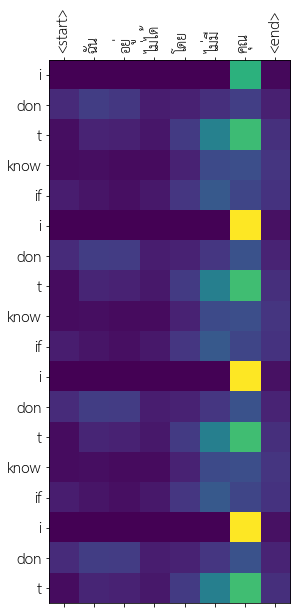

In [36]:
translate('ฉันอยู่ไม่ได้โดยไม่มีคุณ')

Input: <start> เธอ ชื่อ มา เรีย <end>
Predicted translation: the lion is the king of the king of the king of the king of the king of 


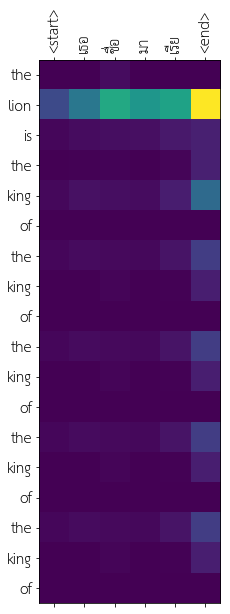

In [37]:
translate('เธอชื่อมาเรีย')

Input: <start> ฉัน รัก คุณ <end>
Predicted translation: you re in . <end> 


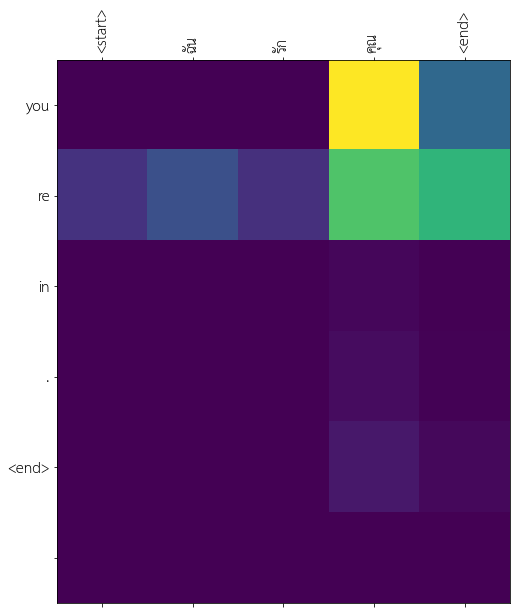

In [40]:
translate('ฉันรักคุณ')

Input: <start> ฉัน คิดถึง คุณ <end>
Predicted translation: i like you . <end> 


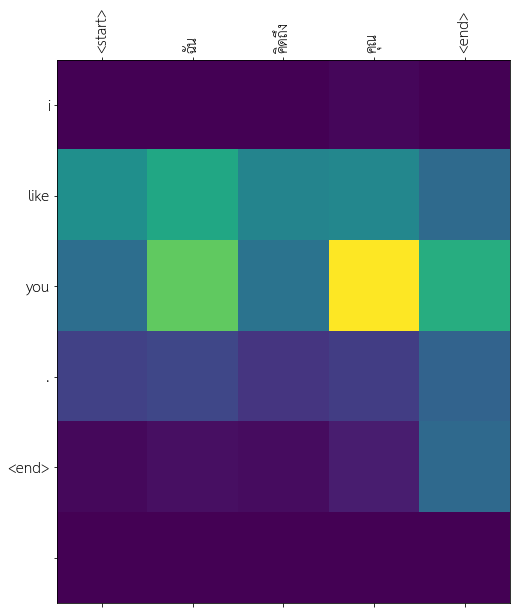

In [41]:
translate('ฉันคิดถึงคุณ')

Input: <start> ฉัน คิด ว่า คุณ พูด ถูก <end>
Predicted translation: i think you re right . <end> 


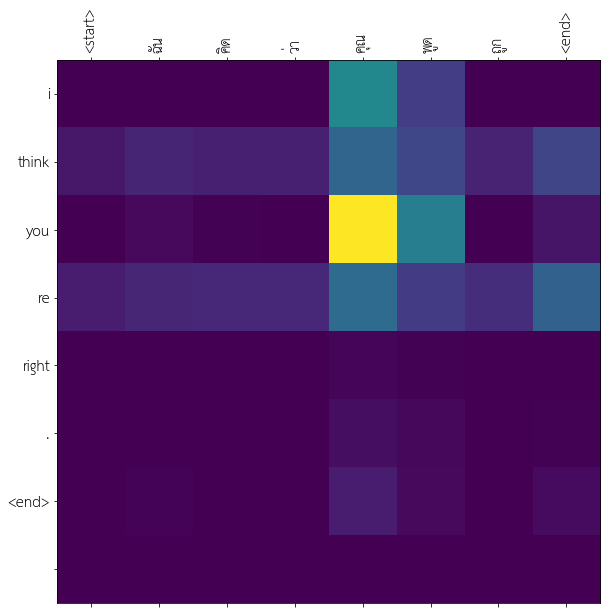

In [39]:
translate('ฉันคิดว่าคุณพูดถูก')